# Patch Distribution Analysis

This notebook analyzes the patch_Manual_Evaluation.xlsx file to visualize how many unique CWEs were fixed by Rule-based vs LLM-based approaches.

## 1. Import Required Libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load the Excel File

In [8]:
# Load the Excel file
file_path = Path('data/Patch_Manual_Evaluation.xlsx')

# Read the Excel file
df = pd.read_excel(file_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Dataset shape: (34, 5)

Columns: ['workflow', 'CWE Found', 'Rule', 'LLM', 'dataset']


## 3. Count Unique CWEs by Category

In [9]:
# Count unique CWEs in Rule and LLM columns
# Each row may have a CWE value in either Rule or LLM column (or both)
# CWEs may be separated by semicolons (e.g., "22;703")
# Note: CWEs are normalized so that 078 and 78 are treated as the same

def extract_individual_cwes(series):
    """Extract and parse individual CWEs from a series, splitting by semicolon and normalizing numbers."""
    cwes = []
    for value in series.dropna():
        # Convert to string and split by semicolon
        cwe_str = str(value).strip()
        if cwe_str:
            # Split by semicolon and clean each CWE
            individual_cwes = [cwe.strip() for cwe in cwe_str.split(';') if cwe.strip()]
            # Normalize CWE numbers by removing leading zeros (078 -> 78)
            normalized_cwes = []
            for cwe in individual_cwes:
                try:
                    # Convert to int and back to string to remove leading zeros
                    normalized_cwes.append(str(int(cwe)))
                except ValueError:
                    # If not a number, keep as is
                    normalized_cwes.append(cwe)
            cwes.extend(normalized_cwes)
    return cwes

# Extract individual CWEs from each column
rule_cwes = extract_individual_cwes(df['Rule'])
llm_cwes = extract_individual_cwes(df['LLM'])

# Get unique CWEs
rule_cwes_unique = sorted(set(rule_cwes))
llm_cwes_unique = sorted(set(llm_cwes))

# Count unique CWEs for each category
rule_count = len(rule_cwes_unique)
llm_count = len(llm_cwes_unique)

# Create distribution dataframe
cwe_distribution = pd.DataFrame({
    'Fix_Method': ['Rule', 'LLM'],
    'Unique_CWEs': [rule_count, llm_count]
})

print("CWE Distribution by Fix Method (after splitting):")
print(cwe_distribution)
print(f"\nUnique CWEs fixed by Rule: {rule_count}")
print(f"Unique CWEs fixed by LLM: {llm_count}")

# Check for overlap
overlap = set(rule_cwes_unique) & set(llm_cwes_unique)
print(f"\nCWEs fixed by BOTH methods: {len(overlap)}")
if len(overlap) > 0:
    print(f"Overlapping CWEs: {sorted(overlap)}")


CWE Distribution by Fix Method (after splitting):
  Fix_Method  Unique_CWEs
0       Rule           14
1        LLM            8

Unique CWEs fixed by Rule: 14
Unique CWEs fixed by LLM: 8

CWEs fixed by BOTH methods: 0


### 3.1 Display Unique CWEs by Method

UNIQUE CWEs IDENTIFIED BY PATCH METHOD

Total unique CWEs in Rule column: 14
Total unique CWEs in LLM column: 8


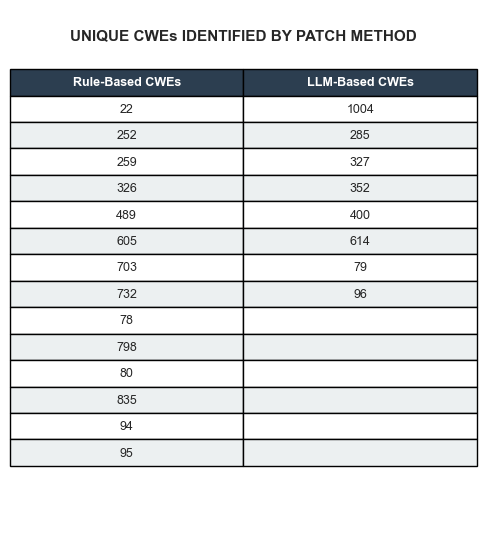

In [10]:
# Create a comprehensive table showing unique CWEs for each method
# CWEs are now individual values after splitting by semicolon

# Create a DataFrame with CWEs side by side
max_len = max(len(rule_cwes_unique), len(llm_cwes_unique))

# Pad the shorter list with None values
rule_cwes_padded = rule_cwes_unique + [None] * (max_len - len(rule_cwes_unique))
llm_cwes_padded = llm_cwes_unique + [None] * (max_len - len(llm_cwes_unique))

# Create the comparison table
cwe_table = pd.DataFrame({
    'Rule-Based CWEs': rule_cwes_padded,
    'LLM-Based CWEs': llm_cwes_padded
})

print("="*60)
print("UNIQUE CWEs IDENTIFIED BY PATCH METHOD")
print("="*60)
print(f"\nTotal unique CWEs in Rule column: {len(rule_cwes_unique)}")
print(f"Total unique CWEs in LLM column: {len(llm_cwes_unique)}")

# Create table visualization as image
fig, ax = plt.subplots(figsize=(5, 5.5))
ax.axis('tight')
ax.axis('off')

# Replace None with empty string for display
display_table = cwe_table.fillna('')

# Create table without index
table = ax.table(cellText=display_table.values,
                colLabels=display_table.columns,
                cellLoc='center',
                loc='center',
                colColours=['#3498db', '#e74c3c'])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.3)

# Style header cells
for i in range(len(display_table.columns)):
    cell = table[(0, i)]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('#2c3e50')

# Alternate row colors for better readability
for i in range(1, len(display_table) + 1):
    for j in range(len(display_table.columns)):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('white')

plt.title('UNIQUE CWEs IDENTIFIED BY PATCH METHOD', 
          fontsize=11, fontweight='bold', pad=-22)
plt.tight_layout()
plt.show()


### 3.2 CWE Overlap Analysis

In [11]:
# Analyze which CWEs are unique to each method and which overlap
rule_only = set(rule_cwes_unique) - set(llm_cwes_unique)
llm_only = set(llm_cwes_unique) - set(rule_cwes_unique)
both_methods = set(rule_cwes_unique) & set(llm_cwes_unique)

# Create a summary table
overlap_summary = pd.DataFrame({
    'Category': ['Rule Only', 'LLM Only', 'Both Methods'],
    'Count': [len(rule_only), len(llm_only), len(both_methods)]
})

print("="*60)
print("CWE OVERLAP ANALYSIS")
print("="*60)
print(overlap_summary.to_string(index=False))

if len(both_methods) > 0:
    print(f"\n\nCWEs fixed by BOTH methods ({len(both_methods)}):")
    print(", ".join(sorted([str(cwe) for cwe in both_methods])))

if len(rule_only) > 0:
    print(f"\n\nCWEs ONLY in Rule ({len(rule_only)}):")
    print(", ".join(sorted([str(cwe) for cwe in rule_only])))

if len(llm_only) > 0:
    print(f"\n\nCWEs ONLY in LLM ({len(llm_only)}):")
    print(", ".join(sorted([str(cwe) for cwe in llm_only])))


CWE OVERLAP ANALYSIS
    Category  Count
   Rule Only     14
    LLM Only      8
Both Methods      0


CWEs ONLY in Rule (14):
22, 252, 259, 326, 489, 605, 703, 732, 78, 798, 80, 835, 94, 95


CWEs ONLY in LLM (8):
1004, 285, 327, 352, 400, 614, 79, 96


## 4. Create Patch Distribution Chart

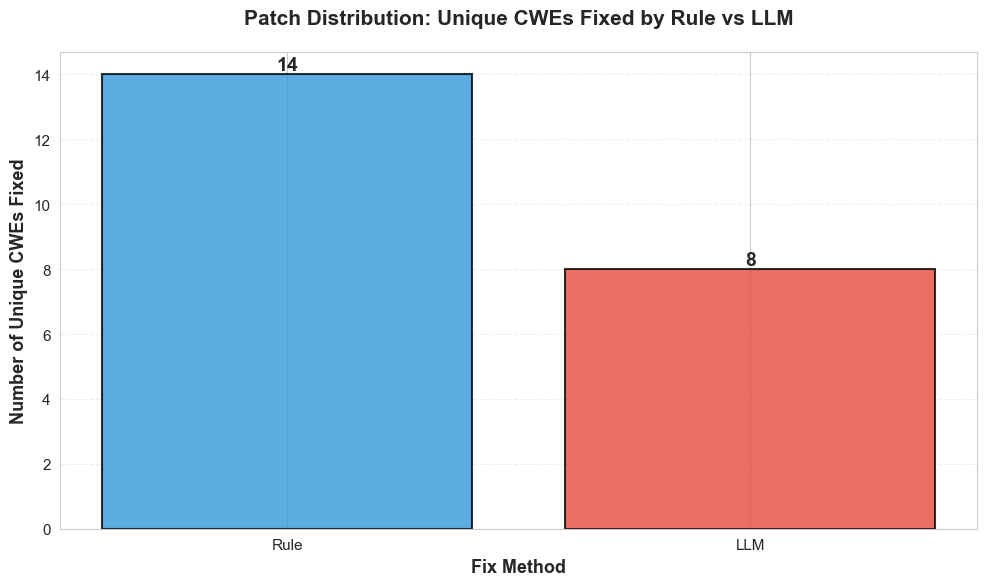


Chart generated successfully!


In [12]:
# Create a bar chart showing unique CWEs fixed by Rule vs LLM
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar chart
colors = ['#3498db', '#e74c3c']  # Blue for Rule, Red for LLM
bars = ax.bar(cwe_distribution['Fix_Method'], cwe_distribution['Unique_CWEs'], 
              color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Customize the chart
ax.set_xlabel('Fix Method', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Unique CWEs Fixed', fontsize=13, fontweight='bold')
ax.set_title('Patch Distribution: Unique CWEs Fixed by Rule vs LLM', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Set y-axis to start from 0
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print("Chart generated successfully!")